In [1]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv, Linear, SAGEConv, GATv2Conv, GATConv
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

import networkx as nx
import numpy as np
from pathlib import Path
import scipy as sp
rng = np.random.default_rng()
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Comptuer Modern",
    "font.size"   : 12
})

In [2]:
def compute_cascade_likelihood(edge_probs, edge_index, cascade, epsilon=1e-8):
  """
  Compute the likelihood of observing a single cascade given edge probabilities.
  
  Args:
  - edge_probs: Tensor of predicted edge probabilities
  - edge_index: Tensor of shape [2, num_edges] containing edge indices
  - cascade: List of lists, where each inner list contains nodes activated at that time step
  - epsilon: Small value to avoid log(0)
  
  Returns:
  - log_likelihood: Log-likelihood of the cascade
  """
  device = edge_probs.device
  num_nodes = edge_index.max().item() + 1
  activated = torch.zeros(num_nodes, dtype=torch.bool, device=device)
  log_likelihood = 0.0

  src, dst = edge_index

  for t in range(len(cascade)):
    prev_activated = torch.tensor(cascade[t-1] if t-1 >= 0 else [], device=device)
    curr_activated = torch.tensor(cascade[t], device=device)
    next_activated = torch.tensor(cascade[t+1] if t+1 < len(cascade) else [], device=device)
    activated[curr_activated] = True
    
    for v in curr_activated:
      # Probability of activation from parents
      parents = src[(dst == v) & activated[src]]
      activated_parents = parents[torch.isin(parents, prev_activated)]
      if len(activated_parents) > 0:
        prob_v_activated = 1 - torch.prod(1 - edge_probs[torch.isin(src, activated_parents) & (dst == v)])
        log_likelihood += torch.log(prob_v_activated + epsilon)

      # Probability of non-activation of children
      children = dst[(src == v) & ~activated[dst]]
      non_activated_children = children[~torch.isin(children, next_activated)]
      if len(non_activated_children) > 0:
        prob_children_not_activated = torch.prod(1 - edge_probs[(src == v) & torch.isin(dst, non_activated_children)])
        log_likelihood += torch.log(prob_children_not_activated + epsilon)
        
  return log_likelihood

def compute_loss(edge_probs, edge_index, cascades):
  """
  Compute the negative log-likelihood loss for multiple cascades.
  
  Args:
  - edge_probs: Tensor of predicted edge probabilities
  - edge_index: Tensor of shape [2, num_edges] containing edge indices
  - cascades: List of cascades, where each cascade is a list of lists of activated nodes
  
  Returns:
  - loss: Negative log-likelihood loss
  """
  total_log_likelihood = 0.0
  for cascade in cascades:
    total_log_likelihood += compute_cascade_likelihood(edge_probs, edge_index, cascade)
  
  # Return negative log-likelihood as the loss
  return -total_log_likelihood

In [3]:
class GNNIndependentCascade(torch.nn.Module):
  def __init__(self, node_emb_dim, hidden_dim, n_nodes, n_edges, num_layers=2):
    super(GNNIndependentCascade, self).__init__()
    self.n = n_nodes
    self.m = n_edges

    self.num_layers = num_layers

    self.node_embed = nn.Embedding(self.n, node_emb_dim)
    self.edge_embed = nn.Parameter(torch.Tensor(self.n, self.n, hidden_dim))

    self.convs = nn.ModuleList([
      GATConv(node_emb_dim if i == 0 else hidden_dim, hidden_dim) 
      for i in range(num_layers)
    ])

    self.edge_predictor = nn.Sequential(
      nn.Linear(2*hidden_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, 1),
    )
    #nn.Linear(hidden_dim, 1)

  def forward(self, data):
    edge_index = data.edge_index
    x = self.node_embed(torch.arange(self.n))

    src, dst = edge_index
    edge_emb = self.edge_embed[src, dst]

    # Node embedding
    for i in range(self.num_layers):
      #x = self.convs[i](x, edge_index, edge_emb)
      x = self.convs[i](x, edge_index)
      x = F.gelu(x)
      x = torch.dropout(x, p=0.1, train=self.training)

    # Edge probability prediction
    #edge_repr = torch.cat([x[src], x[dst]], dim=1)
    edge_repr = torch.cat([torch.add(x[src], x[dst]), edge_emb], dim=1)
    edge_probs = torch.sigmoid(self.edge_predictor(edge_repr))

    #edge_probs = torch.sigmoid(torch.sum(x[row] * x[col], dim=1))

    return edge_probs

def train_model(model, optimizer, data, cascades, num_epochs, batch_size = 50):
  model.train()
  #batches = DataLoader(cascades, batch_size=10, shuffle=True)
  #print(batches)

  print(f"Training model (k = {len(cascades)})...")
  for epoch in range(num_epochs):
    loss = 0.0
    rng.shuffle(cascades)
    batches = [cascades[i:i+batch_size] for i in range(0, len(cascades), batch_size)]

    for batch in batches:
      optimizer.zero_grad()
      edge_probs = model.forward(data)

      batch_loss = compute_loss(edge_probs, data.edge_index, batch)
      batch_loss.backward()
      optimizer.step()
      loss += batch_loss.item()
    
    if epoch % 10 == 0 or epoch == num_epochs - 1:
      print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {loss / len(cascades):.4f}")
  
  print("Training complete.\n")

In [4]:
def create_dataset(G: nx.DiGraph, features):
  edge_index = torch.tensor(list(G.edges)).t().contiguous()
  data = Data(x=features, edge_index=edge_index)
  return data

n = 100
p = 0.1
gname = f"er_{n}_{str(p).replace('.', '')}"
path = Path(f"datasets/synthetic/{gname}")

with open(path / f"graph.mtx", "rb") as fh:
  G = nx.from_scipy_sparse_array(sp.io.mmread(fh), create_using=nx.DiGraph)

In [6]:
l1_errors = []
medians = []
quartile1s = []
quartile3s = []
probs = []

cascades = []
#idxes = rng.choice(1000, 250, replace=False)
for i in range(250):
  with open(path / f"diffusions/timestamps/{i}.txt", "r") as fh:
    cascade = []
    for line in fh:
      cascade.append(list(map(int, line.strip().split())))
    cascades.append(cascade)

#for k in (50, 100, 150, 200, 250):
k = 100
k_cascades = cascades[:k]

n = G.number_of_nodes()
m = G.number_of_edges()
features = torch.eye(n)
data = create_dataset(G, features)

model = GNNIndependentCascade(64, 16, n, m, num_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
train_model(model, optimizer, data, k_cascades, 30, len(k_cascades) // 4)

model.eval()
print("")

Training model (k = 100)...
Epoch 1/30, Avg Loss: nan


KeyboardInterrupt: 

In [21]:
edge_probs = model(data)
k_probs = []

residuals = []
for i, e in enumerate(G.edges()):
  u, v = e
  p = G[u][v]['weight']
  residuals.append(abs(p - edge_probs[i].item()))
  k_probs.append(edge_probs[i].item())

probs.append(k_probs)
l1_errors.append(sum(residuals) / len(residuals))
medians.append(np.median(residuals))
quartile1s.append(np.percentile(residuals, 25))
quartile3s.append(np.percentile(residuals, 75))

print(f"MAE Error: {l1_errors[0]}")
print(f"Median: {medians[0]}, Q1: {quartile1s[0]}, Q3: {quartile3s[0]}")
print(edge_probs)

MAE Error: 0.0962344105105303
Median: 0.07501721677780152, Q1: 0.033743554198169705, Q3: 0.13690943005800246
tensor([[0.1515],
        [0.1624],
        [0.3514],
        [0.1484],
        [0.2464],
        [0.3846],
        [0.1127],
        [0.6354],
        [0.0223],
        [0.4870],
        [0.5183],
        [0.3458],
        [0.6265],
        [0.0311],
        [0.4289],
        [0.4145],
        [0.3299],
        [0.6229],
        [0.6038],
        [0.3562],
        [0.2330],
        [0.5073],
        [0.3864],
        [0.3456],
        [0.3659],
        [0.0219],
        [0.5274],
        [0.2631],
        [0.1943],
        [0.4451],
        [0.2927],
        [0.5784],
        [0.1350],
        [0.5750],
        [0.2198],
        [0.2942],
        [0.0729],
        [0.2936],
        [0.5938],
        [0.2052],
        [0.6252],
        [0.1465],
        [0.0475],
        [0.4688],
        [0.6332],
        [0.0335],
        [0.4618],
        [0.5180],
        [0.2503],
        [

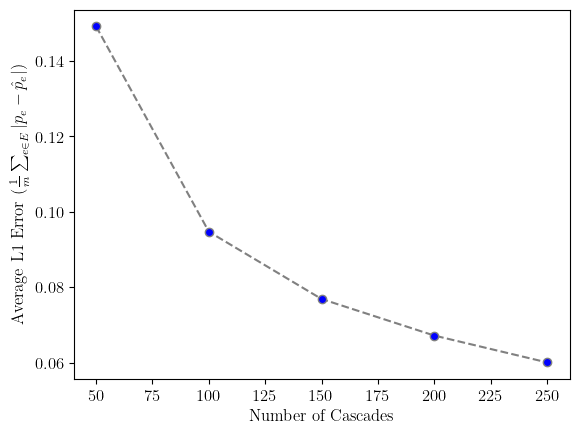

In [44]:
ax, fig = plt.subplots()
fig.plot((50, 100, 150, 200, 250), l1_errors, label="Avg L1 Error", linestyle='--', marker='o', color='gray', markerfacecolor='blue')
#fig.scatter((50, 100, 150, 200, 250), medians, label="Median")
#fig.scatter((50, 100, 150, 200, 250), quartile1s, label="1st Quartile")
#fig.scatter((50, 100, 150, 200, 250), quartile3s, label="3rd Quartile")

plt.xlabel("Number of Cascades")
plt.ylabel(r"Average L1 Error $(\frac{1}{m} \sum_{e \in E} | p_e - \hat{p}_e |)$")
#plt.legend()
plt.savefig("figs/m1_plot.png", dpi=300, bbox_inches='tight')

In [18]:
for i, k in enumerate((50, 100, 150, 200, 250)):
  with open(path / f"probs/{k}.txt", "w") as fh:
    for p in probs[i]:
      fh.write(f"{p:.6f}\n")

In [45]:
print(l1_errors)

[0.14916746752274268, 0.09472653568538095, 0.07688556758801862, 0.06718936878994637, 0.06007313081040892]
